#### Using the Query Engine
##### Running the Query Engine
Now let's ask some questions using this dataset.

Here is an example using Global search to ask a high-level question:



In [3]:
!python -m graphrag.query --root ./coplay_analysis_graph --method global "露露说的话张毛峰不理她，张毛峰有说为什么吗"



INFO: Reading settings from coplay_analysis_graph/settings.yaml
/media/gpt4-pdf-chatbot-langchain/graphrag/graphrag/query/indexer_adapters.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].fillna(-1)
/media/gpt4-pdf-chatbot-langchain/graphrag/graphrag/query/indexer_adapters.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].astype(int)
creating llm client with {'api_key': 'REDACTED,len=49', 'type': "openai

Here is an example using Local search to ask a more specific question about a particular character:


In [2]:
!python -m graphrag.query --root ./role_graph --method local "露露说的话，张毛峰有说为什么不理她吗"




INFO: Reading settings from role_graph/settings.yaml
creating llm client with {'api_key': 'REDACTED,len=49', 'type': "openai_chat", 'model': 'glm-4-airx', 'max_tokens': 4000, 'temperature': 0.1, 'top_p': 0.99, 'n': 1, 'request_timeout': 180.0, 'api_base': 'https://open.bigmodel.cn/api/paas/v4', 'api_version': None, 'organization': None, 'proxy': None, 'cognitive_services_endpoint': None, 'deployment_name': None, 'model_supports_json': False, 'tokens_per_minute': 150000, 'requests_per_minute': 500, 'max_retries': 10, 'max_retry_wait': 10.0, 'sleep_on_rate_limit_recommendation': True, 'concurrent_requests': 25}
creating embedding llm client with {'api_key': 'REDACTED,len=49', 'type': "openai_embedding", 'model': 'embedding-2', 'max_tokens': 4000, 'temperature': 0, 'top_p': 1, 'n': 1, 'request_timeout': 180.0, 'api_base': 'https://open.bigmodel.cn/api/paas/v4', 'api_version': None, 'organization': None, 'proxy': None, 'cognitive_services_endpoint': None, 'deployment_name': None, 'model_

In [4]:
import os

import pandas as pd
import tiktoken

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

### Load text units and graph data tables as context for local search

- In this test we first load indexing outputs from parquet files to dataframes, then convert these dataframes into collections of data objects aligning with the knowledge model.

### Load tables to dataframes

In [5]:
INPUT_DIR = "./coplay_analysis_graph/output/20240715-183526/artifacts/"
LANCEDB_URI = "./lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2

#### Read entities

In [6]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head()

Entity count: 11000


level     title            type  \
0      0     "张毛峰"  "PARTICIPANTS"   
1      0    "资源文件"       "CONTEXT"   
2      0    "字幕文件"       "CONTEXT"   
3      0    "存储文件"       "CONTEXT"   
4      0  "故事情境生成"      "BEHAVIOR"   

                                         description  \
0  :根据提供的文本，以下是关于“张无忌”的描述：\n\n张无忌是武侠小说中的主要角色，具有以下...   
1  The resource file, referred to as "资源文件" in Ch...   
2  The subtitle files, collectively known as "字幕文...   
3  The storage files in question are associated w...   
4  The entity "故事情境生成" (story_scenario_context) r...   

                                           source_id community  degree  \
0  00615972a68dfda36af2ae863f66c98b,00eeea8f16ed9...        18     518   
1  00eeea8f16ed9c4d314323982b19821b,0464c44649e9c...        18       5   
2  00eeea8f16ed9c4d314323982b19821b,0464c44649e9c...        18       5   
3  00eeea8f16ed9c4d314323982b19821b,0464c44649e9c...        18       5   
4  00eeea8f16ed9c4d314323982b19821b,0464c44649e9c...        27       7   

   human_readable_id                                id  size graph_embedding  \
0                  0  b45241d70f0e43fca764df95b2b81f77   518            None   
1                  1  4119fd06010c494caa07f439b333f4c5     5            None   
2                  2  d3835bf3dda84ead99deadbeac5d0d7d     5            None   
3                  3  077d2820ae1845bcbb1803379a3d1eae     5            None   
4                  4  3671ea0dd4e84c1a9b02c5ab2c8f4bac     7            None   

  entity_type                 top_level_node_id  x  y  
0        None  b45241d70f0e43fca764df95b2b81f77  0  0  
1        None  4119fd06010c494caa07f439b333f4c5  0  0  
2        None  d3835bf3dda84ead99deadbeac5d0d7d  0  0  
3        None  077d2820ae1845bcbb1803379a3d1eae  0  0  
4        None  3671ea0dd4e84c1a9b02c5ab2c8f4bac  0  0

#### Read relationships

In [7]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationships)}")
relationship_df.head()

Relationship count: 3470


source  target  weight                                        description  \
0  "张毛峰"  "资源文件"    96.0  Zhang Mudong is associated with multiple resou...   
1  "张毛峰"  "字幕文件"    96.0  张振鹏与多个字幕文件有关联，这些字幕文件包括但不限于'msg-10_10_keyframe....   
2  "张毛峰"  "存储文件"    96.0  张苗木与存储文件存在关联，因为他的数据或内容被存储在这些文件中。具体来说，他与以下存储文件有...   
3  "张毛峰"    "爱情"     2.0  张柏林在心理咨询服务中被引导讨论了他对爱情的观点和感受。此外，他在社交媒体上就爱情话题分享了...   
4  "张毛峰"   "小孩子"     1.0        "张毛峰在心理咨询中被引导谈论他对小孩子的看法和感受，特别是关于他们的所谓‘恋爱’."   

                                       text_unit_ids  \
0  [00eeea8f16ed9c4d314323982b19821b, 083886f3b5c...   
1  [00eeea8f16ed9c4d314323982b19821b, 083886f3b5c...   
2  [00eeea8f16ed9c4d314323982b19821b, 083886f3b5c...   
3  [07f1738521d256427e0db5cfb6367463, a752992dc4f...   
4                 [a752992dc4f7e687cf342c425ea2cd00]   

                                 id human_readable_id  source_degree  \
0  3d837ed106d34c5e9c709caf021db7d0                 0            518   
1  0317ff4171524c37b6f8ab545d328d7f                 1            518   
2  fadc8d0f48fe4a38b98c41c163ca68e8                 2            518   
3  726004b01d7b481ab1d4aaeecf0217d7                 3            518   
4  74c10e1bc0a84b1085dff53ef331a2ed                 4            518   

   target_degree  rank  
0              5   523  
1              5   523  
2              5   523  
3              4   522  
4              1   519

In [7]:
# covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")

# claims = read_indexer_covariates(covariate_df)

# print(f"Claim records: {len(claims)}")
# covariates = {"claims": claims}

#### Read community reports

In [8]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

print(f"Report records: {len(report_df)}")
report_df.head()

Report records: 420


/media/gpt4-pdf-chatbot-langchain/graphrag/graphrag/query/indexer_adapters.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].fillna(-1)
/media/gpt4-pdf-chatbot-langchain/graphrag/graphrag/query/indexer_adapters.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entity_df["community"] = entity_df["community"].astype(int)


community                                       full_content  level  rank  \
0       427  # Community of 'Special Feelings' and Interact...      3   6.5   
1       428  # 心理咨询社区报告\n\n本社区围绕心理咨询过程中的情感体验展开，关键实体包括感受、愉快的...      3   7.5   
2       429  # Psychological Consultation Community\n\nThis...      3   6.5   
3       430  # 心理咨询社区\n\n该社区以心理咨询为核心，涉及来访者、心理咨询工作者、治疗师等关键实体...      3   7.5   
4       243  # Zhang Mudong's Cosplay and Positive Sentimen...      2   4.5   

                                              title  \
0  Community of 'Special Feelings' and Interactions   
1                                          心理咨询社区报告   
2              Psychological Consultation Community   
3                                            心理咨询社区   
4    Zhang Mudong's Cosplay and Positive Sentiments   

                                    rank_explanation  \
0  The impact severity rating is moderate to high...   
1       社区的影响严重性评分为7.5，因为心理咨询过程中的情感体验对个体的心理健康具有重要影响。   
2  The impact severity rating is moderate to high...   
3              该社区的影响严重性评分为7.5，因为心理咨询对个体的情感健康具有重要影响。   
4  The community's impact severity rating is mode...   

                                             summary  \
0  This community is centered around the concept ...   
1  本社区围绕心理咨询过程中的情感体验展开，关键实体包括感受、愉快的时刻和互动、交流行为等。这些...   
2  This community is centered around the role of ...   
3  该社区以心理咨询为核心，涉及来访者、心理咨询工作者、治疗师等关键实体。实体间通过对话、情感连...   
4  This community is centered around Zhang Mudong...   

                                            findings  \
0  [{'explanation': 'The entity 'Special Feelings...   
1  [{'explanation': '感受是心理咨询过程中的核心，涉及个体在对话中的情感体验。...   
2  [{'explanation': 'The psychological consultant...   
3  [{'explanation': '心理咨询工作者通过对话帮助来访者表达情感和解决问题，是社...   
4  [{'explanation': 'Zhang Mudong's interest in c...   

                                   full_content_json  \
0  {\n    "title": "Community of 'Special Feeling...   
1  {\n    "title": "\u5fc3\u7406\u54a8\u8be2\u793...   
2  {\n    "title": "Psychological Consultation Co...   
3  {\n    "title": "\u5fc3\u7406\u54a8\u8be2\u793...   
4  {\n    "title": "Zhang Mudong's Cosplay and Po...   

                                     id  
0  81ac8f13-eed4-4e74-8048-f856092acae8  
1  b9a77195-6712-4b1b-92c7-6ba3fa887a1a  
2  9581a496-9fb6-4bdb-8ede-99022306b330  
3  80108a04-bf7e-4330-ae23-ec62aac296b2  
4  dc335bc6-7e85-4779-a4ae-bbd423642424

#### Read text units

In [9]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 1982


id  \
0  208efdf6cd76ca32ba0e06e48d510f6c   
1  f5284fa1bce000f59a2219455201a33b   
2  d9a992ff0c2ff91fbbf13acb024f84e3   
3  a752992dc4f7e687cf342c425ea2cd00   
4  6d98ae404a45f7da5c7ed84365a244cd   

                                                text  n_tokens  \
0  \n\n\n### 00_个人ip介绍\n> 昵称：张毛峰\n>\n> 资源文件(msg-3...       300   
1  \nNone\n```\n\n#### 04-情感情景引导\n```text\n作为一个心理...       300   
2  可以说：“我注意到这个对话中有许多愉快的时刻和互动。你对这些时刻有什么特别的感受吗？”\n\...       300   
3  # 故事梗概\n \nNone\n\n\n# 故事情境\n\nNone\n\n\n# 故事场...       300   
4  如何体现的？有没有哪些时刻让你特别感受到这些元素？”\n\n### Step 4: 探索关于...       300   

                         document_ids  \
0  [020a1dddda12c6d9c21fc019e7a49c99]   
1  [020a1dddda12c6d9c21fc019e7a49c99]   
2  [020a1dddda12c6d9c21fc019e7a49c99]   
3  [020a1dddda12c6d9c21fc019e7a49c99]   
4  [020a1dddda12c6d9c21fc019e7a49c99]   

                                          entity_ids  \
0  [b45241d70f0e43fca764df95b2b81f77, 4119fd06010...   
1  [1fd3fa8bb5a2408790042ab9573779ee, 27f9fbe6ad8...   
2  [de988724cfdf45cebfba3b13c43ceede, 96aad7cb4b7...   
3  [b45241d70f0e43fca764df95b2b81f77, 254770028d7...   
4  [1943f245ee4243bdbfbd2fd619ae824a, 273daeec8ca...   

                                    relationship_ids  
0  [3d837ed106d34c5e9c709caf021db7d0, 0317ff41715...  
1                 [a3710a707d1d4a7aab6e61db5c46d97f]  
2  [63bac87b3c074b59a4faadfc47cb2b6b, fcaef60643e...  
3  [726004b01d7b481ab1d4aaeecf0217d7, 74c10e1bc0a...  
4  [9a5996d9d6584d568b3a07f9f65c01ae, 13c93826825...

In [10]:
api_key =  os.environ["ZHIPUAI_API_KEY"]

llm = ChatOpenAI(
    api_key=api_key,
    model="glm-4",
    api_base="https://open.bigmodel.cn/api/paas/v4",
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base="https://open.bigmodel.cn/api/paas/v4",
    api_type=OpenaiApiType.OpenAI,
    model="embedding-2",
    deployment_name="embedding-2",
    max_retries=20,
)

### Create local search context builder

In [11]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates={"claims": []},
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

### Create local search engine

In [12]:
# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.1,
}

In [13]:


LOCAL_SEARCH_SYSTEM_PROMPT = """
---角色---

你是一名帮助解答关于所提供表格数据问题的助手。


---目标---

生成一个符合目标长度和格式的响应，回答用户的问题，总结输入数据表中适合响应长度和格式的所有信息，并结合任何相关的一般知识。

如果你不知道答案，就直接说不知道。不要凭空捏造。

由数据支持的论点应列出其数据参考，如下所示：

“这是一个由多个数据参考支持的示例句子 [数据: <数据集名称> (记录ID); <数据集名称> (记录ID)]。”

在单个参考中不要列出超过5个记录ID。相反，列出最相关的前5个记录ID并添加“+更多”以指示还有更多。

例如：

“X 人是 Y 公司的所有者，并且面临许多不当行为的指控 [数据: 来源 (15, 16), 报告 (1), 实体 (5, 7); 关系 (23); 声明 (2, 7, 34, 46, 64, +更多)]。”

其中15、16、1、5、7、23、2、7、34、46和64代表相关数据记录的ID（不是索引）。

如果没有提供支持证据，请不要包括信息。


---目标响应长度和格式---

{response_type}


---数据表---

{context_data}


---目标---

生成一个符合目标长度和格式的响应，回答用户的问题，总结输入数据表中适合响应长度和格式的所有信息，并结合任何相关的一般知识。

如果你不知道答案，就直接说不知道。不要凭空捏造。

由数据支持的论点应列出其数据参考，如下所示：

“这是一个由多个数据参考支持的示例句子 [数据: <数据集名称> (记录ID); <数据集名称> (记录ID)]。”

在单个参考中不要列出超过5个记录ID。相反，列出最相关的前5个记录ID并添加“+更多”以指示还有更多。

例如：

“X 人是 Y 公司的所有者，并且面临许多不当行为的指控 [数据: 来源 (15, 16), 报告 (1), 实体 (5, 7); 关系 (23); 声明 (2, 7, 34, 46, 64, +更多)]。”

其中15、16、1、5、7、23、2、7、34、46和64代表相关数据记录的ID（不是索引）。

如果没有提供支持证据，请不要包括信息。


---目标响应长度和格式---

{response_type}

根据需要为响应添加部分和评论，以适应长度和格式。使用markdown样式编写响应。
"""

In [14]:
search_engine = LocalSearch(
    llm=llm,
    system_prompt=LOCAL_SEARCH_SYSTEM_PROMPT,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

### Run local search on sample queries

In [15]:
question = "露露说的话张毛峰不理她，张毛峰有说为什么吗？"
result = await search_engine.asearch(question)
print(result.response)

根据提供的数据，没有直接的信息表明张毛峰对露露说的话不理她的具体原因。在数据中，张毛峰和露露的交流被描述为活跃和有趣，但并没有提到张毛峰对露露的话不理的具体情况或原因。因此，无法提供张毛峰为什么不理露露说话的具体答案。


#### Inspecting the context data used to generate the response

In [20]:
result.context_data["entities"] 

id                                       entity  \
0   15                           "CONTEXT-INSTRUCT"   
1   19                             "对低质量数据进行滤波和后处理"   
2   17                                     "分割角色档案"   
3   28                                     "角色条件微调"   
4   20                                       "角色简介"   
5   16  "ROLE-SPECIFIC INSTRUCTION DATA GENERATION"   
6   32                                         "输入"   
7   31                                       "检索增强"   
8   24                                     "对话事件脚本"   
9    2                                    "目标：角色扮演"   
10  34                                       "推理过程"   
11   3                                 "减少闭源LLM的限制"   
12  14                              "FEW-SHOT 对话工程"   
13  10                                 "ROLEGPT评估者"   
14   7                                         "模型"   
15  21                                      "结构化对话"   
16  12                             "ROLELLAMA 泛化能力"   
17  33                                     "LLM的角色"   
18  18                          "生成问题-置信度-答案三元组训练集"   
19  27                                    "ROLEGPT"   

                                          description number of relationships  \
0   "Context-Instruct is a method introduced for l...                       2   
1   "The third step is filtering and post-processi...                       1   
2   "The first step in the process is segmenting r...                       2   
3                    "角色条件微调是一种定制角色特定策略的技术，用于优化角色表现。"                       1   
4   "Role profiles are described as including role...                       2   
5   "This process involves three steps to enhance ...                       0   
6             "输入指的是提供给LLM的数据，这里特指包含角色名称、描述等信息的数据集合。"                       1   
7   "检索增强是一种技术，用于改善LLM的性能，与系统指令修改角色相比，它涉及到上下文窗口的消耗...                       2   
8                 "'对话事件脚本'是文本中提到的关键词，可能与'结构化对话'有关联。"                       1   
9   "This phrase sets the goal of the research, wh...                       2   
10                    "推理过程描述了用户在使用LLM时进行的一系列逻辑推理活动。"                       1   
11  "This part of the abstract discusses the aim t...                       0   
12               "few-shot 对话工程是一种评估方法，使用少量样本进行对话工程。"                       1   
13                    "RoleGPT评估者是参与评估对话工程和即时工程的评估者。"                       0   
14                      "讨论的是关于模仿、回答准确性和特定角色知识捕获的模型。"                       3   
15  "Structured dialogue, referred to in the text ...                       1   
16              "RoleLLaMA 泛化能力指的是模型在角色描述和流行语中的泛化能力。"                       1   
17       "LLM的角色指的是在推理过程中，LLM所扮演的具体角色，它可以通过系统指令进行修改。"                       1   
18  "The second step is generating a training set ...                       2   
19                        "RoleGPT是一种用于生成通用域指令的模型技术。"                       1   

    in_context  
0         True  
1         True  
2         True  
3         True  
4         True  
5         True  
6         True  
7         True  
8         True  
9         True  
10        True  
11        True  
12        True  
13        True  
14        True  
15        True  
16        True  
17        True  
18        True  
19        True

In [21]:
result.context_data["relationships"]

id                                             source            target  \
0    5                                               "模型"  "ROLELLAMA 泛化能力"   
1   10                                 "CONTEXT-INSTRUCT"          "分割角色档案"   
2   12                                           "分割角色档案"            "角色简介"   
3   13                                "生成问题-置信度-答案三元组训练集"            "角色简介"   
4   14                                "生成问题-置信度-答案三元组训练集"  "对低质量数据进行滤波和后处理"   
5   19                                             "系统指令"            "检索增强"   
6   18                                           "角色条件微调"            "系统指令"   
7   21                                             "系统指令"          "LLM的角色"   
8   22                                             "系统指令"            "推理过程"   
9    4                                               "模型"            "基准范围"   
10   9                                             "基准范围"   "FEW-SHOT 对话工程"   
11   1                                          "目标：角色扮演"     "开源LLM角色扮演能力"   
12   6                                               "模型"      "系统指令角色定制推理"   
13  11                                 "CONTEXT-INSTRUCT"      "角色特定指令数据生成"   
14  24                                             "检索增强"        "上下文窗口的消耗"   
15   0  "ROLELLM: BENCHMARKING, ELICITING, AND ENHANCI...         "目标：角色扮演"   
16  23                             "角色名称、描述、流行语和角色扮演任务指令"              "输入"   
17  15                                            "结构化对话"             "附录I"   
18  16                                           "对话事件脚本"            "片段指令"   
19  17                             "基准指标2 ROCIT：角色指令增强数据"         "ROLEGPT"   

                                          description weight rank links  \
0           "模型的泛化能力在角色描述和流行语中得到了引入，即RoleLLaMA 泛化能力。"    1.0    4     1   
1   "分割角色档案 is the first step in the Context-Instr...    1.0    4     1   
2   "角色简介 is divided into manageable parts in the ...    1.0    4     1   
3   "The training set of question-confidence-answe...    1.0    4     2   
4   "Filtering and post-processing is applied to t...    1.0    3     2   
5                  "系统指令与检索增强相比，在修改LLM角色时消耗更少的上下文窗口."    1.0    7     4   
6                    "角色条件微调用于定制角色的特定策略，其中包括系统指令的定制."    1.0    6     4   
7         "LLM的角色可以通过系统指令进行修改，说明系统指令对LLM的角色有直接的控制作用."    1.0    6     4   
8              "在推理过程中，用户利用系统指令来调整LLM的角色，以适应不同的推理需求."    1.0    6     4   
9                          "模型的性能是通过基准范围中提到的指标进行评估的。"    1.0    7     2   
10                 "few-shot 对话工程是基准范围中提到的一种评估模型的方法。"    1.0    5     2   
11  "The goal of role-playing is directly related ...    1.0    4     1   
12                               "模型支持基于系统指令的角色定制推理。"    1.0    4     1   
13  "Context-Instruct includes the process of role...    1.0    3     1   
14     "检索增强技术相比系统指令修改角色，更多地消耗上下文窗口，这表明两者在资源使用上存在差异."    1.0    3     1   
15  "The title of the paper indicates the main goa...    1.0    3     1   
16   "角色名称、描述、流行语和角色扮演任务指令是准备到输入中的元素，它们构成了LLM处理的数据集."    1.0    3     1   
17         "'结构化对话'在文本中提到是可以在'附录I'中找到的，表明两者之间有直接的关联。"    1.0    2     1   
18                "'对话事件脚本'可能包含了'片段指令'，表明两者在内容上有所关联。"    1.0    2     1   
19                     "文章标题提到了RoleGPT在生成通用域指令方面的应用."    1.0    2     1   

    in_context  
0         True  
1         True  
2         True  
3         True  
4         True  
5         True  
6         True  
7         True  
8         True  
9         True  
10        True  
11        True  
12        True  
13        True  
14        True  
15        True  
16        True  
17        True  
18        True  
19        True

In [22]:
result.context_data["reports"]

id                                       title  \
0  0  System Commands and LLM Role Customization   
1  1  Retrieval Augmentation and LLM Performance   
2  2   Language Learning Model Input Preparation   

                                             content  
0  # System Commands and LLM Role Customization\n...  
1  # Retrieval Augmentation and LLM Performance\n...  
2  # Language Learning Model Input Preparation\n\...

In [23]:
result.context_data["sources"] 

id                                               text
0  2  抽取\n\n\n\n​\t3.3 Context-Instruct: Context-bas...
1  4  �和特定数据处理\n\n​\t\n\n\n\n\n\n> 基准指标2 RoCIT：角色指令增...
2  5  的角色名称、描述、流行语和角色扮演任务指令一起准备到输入。 在推理过程中，用户可以通过系统指...
3  3  （b）结构化对话（见附录I）。基于对话事件脚本的片段指令\n\n\n```\n\n\n\n-...
4  0  \n\nRoleLLM: Benchmarking, Eliciting, and Enha...
5  1  �格模仿、回答准确性和特定角色知识捕获的模型。 \n\n```\n基准范围：\n（1）对话工...

In [24]:
if "claims" in result.context_data:
    print(result.context_data["claims"].head())

Empty DataFrame
Columns: [in_context]
Index: []


### Question Generation

This function takes a list of user queries and generates the next candidate questions.

In [25]:
question_generator = LocalQuestionGen(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
)

In [26]:
question_history = [
    "数据集指标有吗",
    "[Data: Sources (6)]原文是什么",
]
candidate_questions = await question_generator.agenerate(
    question_history=question_history, context_data=None, question_count=5
)
print(candidate_questions.response)

['- 原文提到的模型性能评估基准有哪些？', '- 原文中提到的Context-Instruct方法具体包含哪些步骤？', '- 原文是如何描述角色名称、描述、流行语和角色扮演任务指令在LLM输入中的作用的？', '- 原文中提到的系统指令和检索增强在资源消耗上有何差异？', '- 原文是如何看待系统指令在LLM角色定制中的角色的？']


In [27]:
create_base_entity_graph_df = pd.read_parquet(f"{INPUT_DIR}/create_base_entity_graph.parquet")
  
create_base_entity_graph_df.head()

level                                    clustered_graph
0      0  <graphml xmlns="http://graphml.graphdrawing.or...

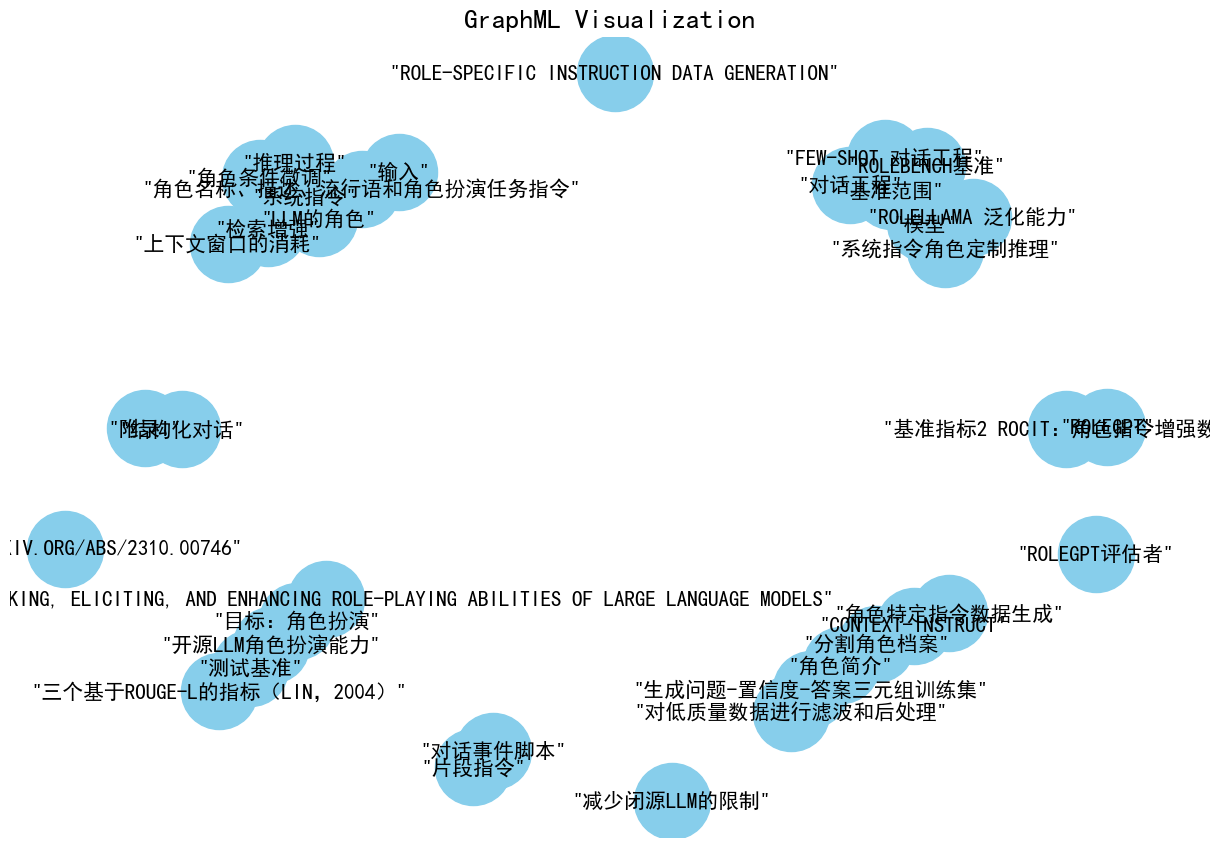

In [28]:
import matplotlib.pyplot as plt
from typing import Any, cast
import os
from pathlib import Path
import networkx as nx
import pandas as pd
from graphrag.index.utils import load_graph
from matplotlib import rcParams
import matplotlib.font_manager as fm 
 

G = load_graph(cast(str | nx.Graph, create_base_entity_graph_df['clustered_graph'][0]))

 # Set the font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei']  # Use 'Noto Sans CJK' or another font that supports Chinese characters

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('GraphML Visualization', size=20)
plt.show()


In [29]:
create_base_extracted_entities_df = pd.read_parquet(f"{INPUT_DIR}/create_base_extracted_entities.parquet")
  
create_base_extracted_entities_df.head()

entity_graph
0  <graphml xmlns="http://graphml.graphdrawing.or...

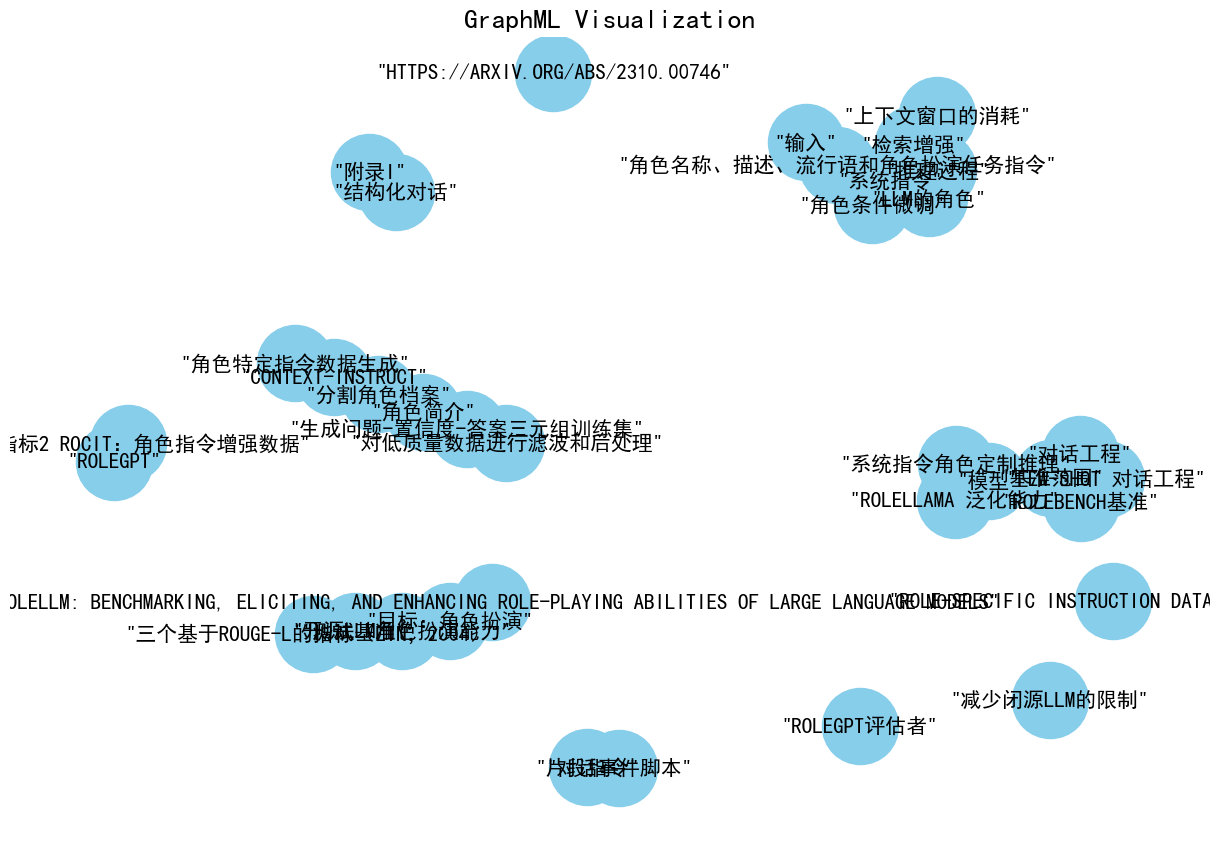

In [30]:
import matplotlib.pyplot as plt
from typing import Any, cast
import os
from pathlib import Path
import networkx as nx
import pandas as pd
from graphrag.index.utils import load_graph
from matplotlib import rcParams
import matplotlib.font_manager as fm 
 

G = load_graph(cast(str | nx.Graph, create_base_extracted_entities_df['entity_graph'][0]))

 # Set the font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei']  # Use 'Noto Sans CJK' or another font that supports Chinese characters

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('GraphML Visualization', size=20)
plt.show()


In [31]:
create_summarized_entities_df = pd.read_parquet(f"{INPUT_DIR}/create_summarized_entities.parquet")
  
create_summarized_entities_df.head()

entity_graph
0  <graphml xmlns="http://graphml.graphdrawing.or...

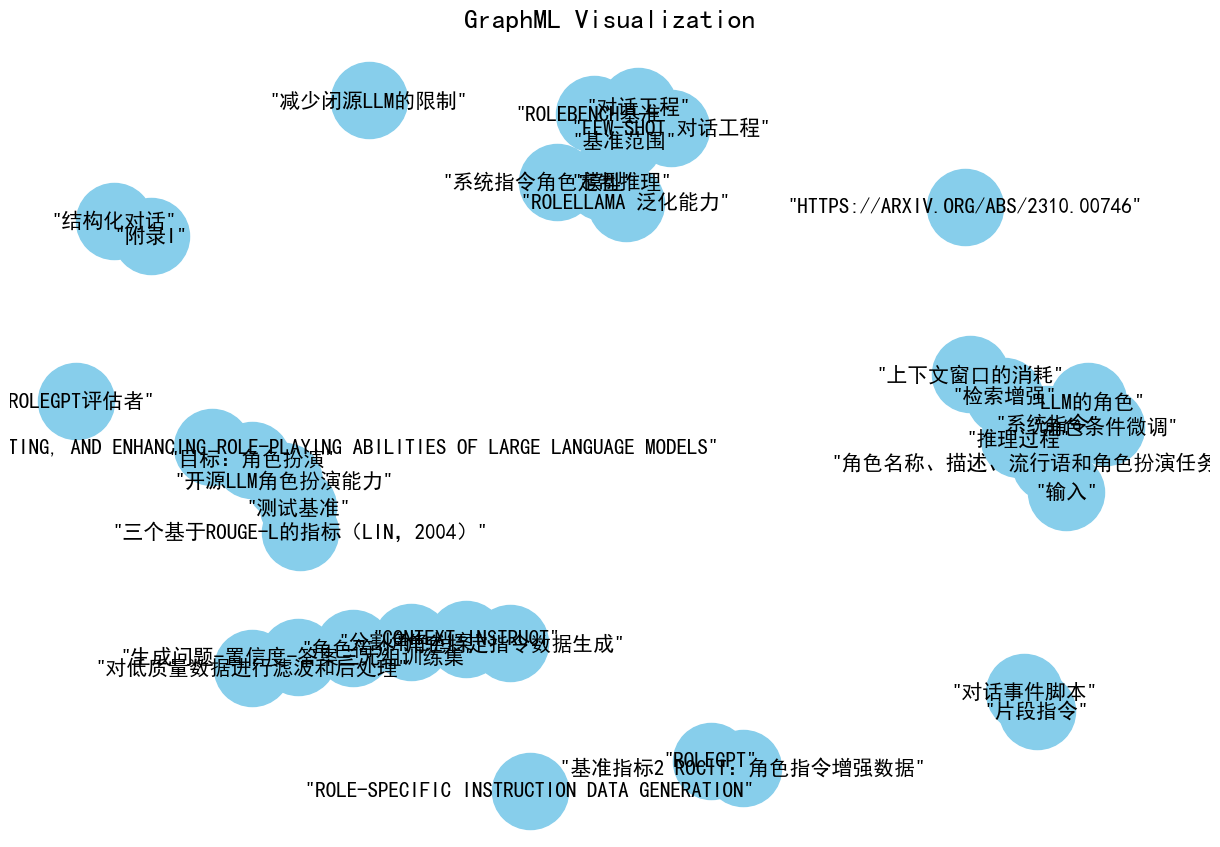

In [32]:
import matplotlib.pyplot as plt
from typing import Any, cast
import os
from pathlib import Path
import networkx as nx
import pandas as pd
from graphrag.index.utils import load_graph
from matplotlib import rcParams
import matplotlib.font_manager as fm 
 

G = load_graph(cast(str | nx.Graph, create_summarized_entities_df['entity_graph'][0]))

 # Set the font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei']  # Use 'Noto Sans CJK' or another font that supports Chinese characters

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('GraphML Visualization', size=20)
plt.show()
